<a href="https://colab.research.google.com/github/w4rr4nt/nlp-project/blob/main/Roberta_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [56]:
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from numpy import arange
from textattack.goal_functions import TargetedClassification
from textattack.transformations import WordSwapEmbedding
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.search_methods import GreedyWordSwapWIR

### Dataset Setup

In [57]:
dataset = datasets.load_dataset('SetFit/enron_spam')

Repo card metadata block was not found. Setting CardData to empty.


In [58]:
dataset

DatasetDict({
    train: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 31716
    })
    test: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 2000
    })
})

In [59]:
test_dataset = dataset['test']

In [60]:
dataset = dataset['train'].train_test_split(test_size=0.2)

In [61]:
train_dataset = dataset['train']
val_dataset = dataset['test']

In [62]:
train_dataset

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
    num_rows: 25372
})

In [63]:
val_dataset

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
    num_rows: 6344
})

In [64]:
test_dataset

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
    num_rows: 2000
})

### Tokenization

In [65]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize(batch):
    return tokenizer(batch["message"], padding=True, truncation=True, max_length=256)

train_map = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
val_map = val_dataset.map(tokenize, batched=True, batch_size=len(val_dataset))
test_map = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

Map:   0%|          | 0/25372 [00:00<?, ? examples/s]

  0%|          | 0/10 [02:28<?, ?it/s]


Map:   0%|          | 0/6344 [00:00<?, ? examples/s]

### Training Distribution

[0.49160492 0.50839508]


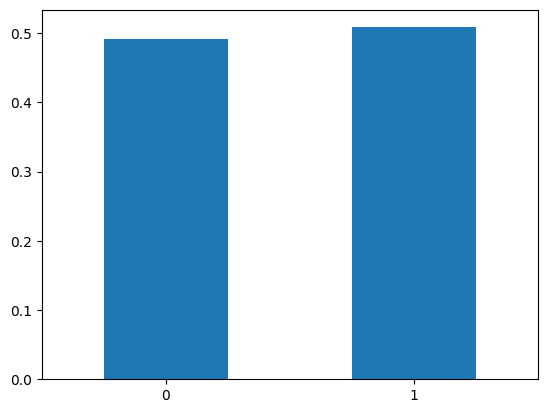

In [66]:
# Get target training  labels and counts of each type of label
bins, counts = np.unique(train_dataset['label'], return_counts=True)
print(counts/len(train_dataset))
# Create frequency series of training data
freq_series = pd.Series(counts/len(train_dataset))
# Create plot
plt.figure()
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

### Validation Distribution

[0.48549811 0.51450189]


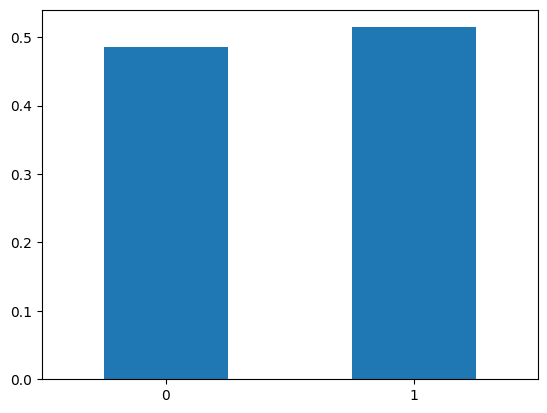

In [67]:
# Get target training  labels and counts of each type of label
bins, counts = np.unique(val_dataset['label'], return_counts=True)
print(counts/len(val_dataset))
# Create frequency series of training data
freq_series = pd.Series(counts/len(val_dataset))
# Create plot
plt.figure()
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

### Testing Distribution

[0.496 0.504]


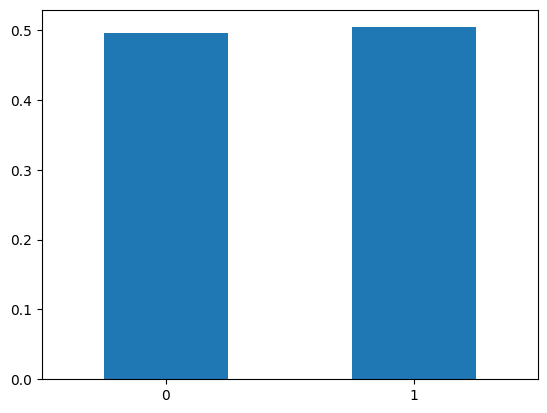

In [68]:
# Get target training  labels and counts of each type of label
bins, counts = np.unique(test_dataset['label'], return_counts=True)
print(counts/len(test_dataset))
# Create frequency series of training data
freq_series = pd.Series(counts/len(test_dataset))
# Create plot
plt.figure()
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

### Dataset Mapping

In [69]:
train_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 25372
})

In [70]:
val_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 6344
})

In [71]:
test_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [72]:
train_map.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_map.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_map.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [73]:
train_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 25372
})

In [74]:
val_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 6344
})

In [75]:
test_map

Dataset({
    features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

### Model Setup

In [76]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.config

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [77]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    learning_rate=0.0001,
    warmup_steps=500,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_map,
    eval_dataset=val_map,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [78]:
#training_output = trainer.train()

Epoch,Training Loss,Validation Loss
1,0.181500,0.058114
2,0.070100,0.045750
3,0.042000,0.037032
4,0.019000,0.048919
5,0.015900,0.038549


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3500 already exists and is non-empty. Saving will proceed but saved res

### Training and Validation Loss

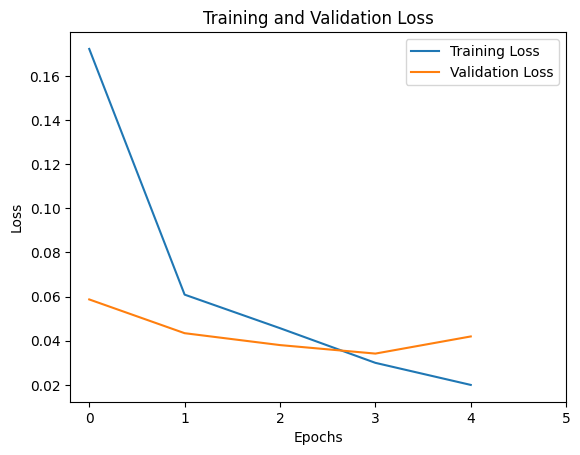

In [26]:
# Retrieve each dictionary's values
train_values = [0.172200, 0.060900, 0.045700, 0.030000, 0.020000]
val_values = [0.058725, 0.043436, 0.038046, 0.034193, 0.041959]

# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, 5)

# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 6))

# Display the plot
plt.legend(loc='best')
plt.show()

### Train and Evaluate

In [79]:
trainer.evaluate()

{'eval_loss': 0.03854909911751747,
 'eval_runtime': 12.1321,
 'eval_samples_per_second': 522.91,
 'eval_steps_per_second': 16.403,
 'epoch': 5.0}

In [80]:
#trainer.save_model('roberta-fine-tune-model')

In [ ]:
trainer.save_model('roberta-fine-tune-model-1.2')

In [81]:
test_predictions = trainer.predict(test_map)

In [82]:
test_preds = test_predictions.predictions.argmax(-1)

In [83]:
print(metrics.classification_report(test_map['label'], test_preds, target_names=['not-spam','spam']))

              precision    recall  f1-score   support

    not-spam       1.00      0.99      0.99       992
        spam       0.99      1.00      0.99      1008

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



### TextAttack

In [87]:
from textattack import Attack
from textattack import Attacker
from textattack.datasets import HuggingFaceDataset
from textattack.models.wrappers import TensorFlowModelWrapper, HuggingFaceModelWrapper

In [85]:
tuned_model = RobertaForSequenceClassification.from_pretrained('./roberta-fine-tune-model')

In [88]:
model_wrapper = HuggingFaceModelWrapper(tuned_model, tokenizer)

In [89]:
dataset = HuggingFaceDataset("SetFit/enron_spam", None, "train", dataset_columns=(['message'],'label'))

Repo card metadata block was not found. Setting CardData to empty.
textattack: Loading datasets dataset SetFit/enron_spam, split train.


In [90]:
target_class = 0  # Adjust based on your dataset and target
goal_function = TargetedClassification(model_wrapper, target_class)
transformation = WordSwapEmbedding()
constraints = [UniversalSentenceEncoder(threshold=0.7)]
search_method = GreedyWordSwapWIR()
attack = Attack(goal_function, constraints, transformation, search_method)

textattack: Unknown if model of class <class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.


In [91]:
attacker = Attacker(attack, dataset)
attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  TargetedClassification(
    (target_class):  0
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.7
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  20%|██        | 2/10 [00:04<00:18,  2.32s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

understanding oem [[software]]
lead me not into [[temptation]] ; i can find the way myself .
# 3533 . the law disregards [[trifles]] .

understanding oem [[agendas]]
lead me not into [[luring]] ; i can find the way myself .
# 3533 . the law disregards [[prattle]] .


--------------------------------------------- Result 2 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

19 th , 2 : 00 pm edt
perspective on ferc regulatory action client conference call
today , tuesday , june 19 th
2 : 00 pm edt
host : ray niles , power / natural gas analyst
speaker : steve bergstrom , president & coo of dynegy
steve bergstrom , president and chief operating officer of dynegy , will join
us at 2 : 00 p . m . today for a conference call discussion of the recent ferc
action imposing price controls in the west . the discussion will be followed
by q & 

[Succeeded / Failed / Skipped / Total] 1 / 1 / 2 / 4:  40%|████      | 4/10 [00:06<00:09,  1.67s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

viagra at $ 1 . 12 per dose
ready to boost your sex life ? positive ?
time to do it right now . order viagra at incredibly low prices
$ 1 . 12 per dose . unbelivable
remove



--------------------------------------------- Result 4 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

teco tap 30 . 000 / enron ; 120 . 000 / hpl gas daily
ls hpl lsk ic 30 . 000 / enron




[Succeeded / Failed / Skipped / Total] 2 / 1 / 2 / 5:  50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (100%)]] --> [[0 (72%)]]

[[water]] past also , [[burn]] , course . gave [[country]] , [[mass]] lot . [[act]] [[north]]
good . from , [[learn]] [[form]] most [[brother]] vary . when more for . up
stick , [[century]] put , song be . test , describe , plain , against [[wood]]
star . began dress ever group . here oh , most world stay .


[[vee]] past also , [[burning]] , course . gave [[sate]] , [[misa]] lot . [[legislation]] [[northern]]
good . from , [[lessons]] [[forming]] most [[siblings]] vary . when more for . up
stick , [[xvi]] put , song be . test , describe , plain , against [[timmer]]
star . began dress ever group . here oh , most world stay .





[Succeeded / Failed / Skipped / Total] 3 / 1 / 2 / 6:  60%|██████    | 6/10 [02:37<01:44, 26.18s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (100%)]] --> [[0 (79%)]]

[[vera]] ,
vcsc - [[brand]] new [[stock]] for [[your]] [[attention]]
vocalscape inc - the stock symbo | is : vcsc
breaking news released by the company on friday after the ciose - watch out the stock go crazy next week .
current price : $ 0 . 175
projected speculative price in next 5 days : $ 0 . 42
projected specuiative price in next 15 days : $ 0 . 55
vocalscape networks inc . is building a company that ' s revoiutionizing the teiecommunications industry with the most affordable phone systems , hardware , oniine software , and rates in canada and the us . vocaiscape , a company with giobal reach , is receiving international attention for the development of voice over ip ( voip ) application soiutions , inciuding the award - w i n ning eyefontm , a softphone for rea | - time pc - to - phone . we are an advanced impiementer of pbx systems for companies , ca

[Succeeded / Failed / Skipped / Total] 4 / 1 / 2 / 7:  70%|███████   | 7/10 [02:37<01:07, 22.56s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (100%)]] --> [[0 (74%)]]

i noticed that you have visited [[illegal]] [[websites]] .
see the name [[in]] the list !
+ + + + attachment : [[no]] [[virus]] [[found]]
+ + + + [[norman]] [[antivirus]] - www . norman . com


i noticed that you have visited [[undocumented]] [[locations]] .
see the name [[for]] the list !
+ + + + attachment : [[nor]] [[measles]] [[spotted]]
+ + + + [[jill]] [[firewall]] - www . norman . com





[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:  90%|█████████ | 9/10 [02:49<00:18, 18.88s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (100%)]] --> [[0 (77%)]]

to : avfs @ fazekas . [[hu]]
attn : [[marketing]] department
from : i . q . software - [[bucharest]]
ref . : romanian software production & [[export]]
[[our]] [[anti]] - spamming company policy :
never bother you again
to remove your e - mail address from the present
contact list just do not reply to this message .
if you receive this message by mistake and / or you are not interested
in the following brief presentation , please accept our apologies .
this is a world - wide promotion campaign . the selected e - mail addresses
are extracted only from the commercial websites of the targeted markets .
we would like to offer you for consideration our brief presentation .
we are looking for a marketplace in your country .
to communicate with us please reply using
the plain text format in the body of the message
> > > mentioning your specific inquiry / offering d

[Succeeded / Failed / Skipped / Total] 6 / 1 / 3 / 10: 100%|██████████| 10/10 [02:55<00:00, 17.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (100%)]] --> [[0 (71%)]]

[[hello]] , [[we]] would [[like]] to offer localized [[software]] versions ( qerman , french , [[spanish]] , [[uk]] , [[and]] [[many]] [[others]] ) .
ail iisted [[software]] [[is]] availabie [[for]] [[immediate]] downioad !
[[no]] [[need]] [[to]] [[wait]] 2 - 3 [[week]] [[for]] [[cd]] deiivery !
[[just]] [[few]] [[examples]] :
- [[norton]] [[lnternet]] [[security]] [[pro]] 2005 - $ 29 . 95
- [[windows]] [[xp]] [[professional]] [[with]] [[sp]] 2 fuii [[version]] - $ 59 . 95
- corel [[draw]] graphics suite 12 - $ 49 . 95
- dreamweaver [[mx]] 2004 ( homesite 5 . 5 inciuding ) - $ 39 . 95
- macromedia [[studio]] [[mx]] 2004 - $ 119 . 95
just [[browse]] [[our]] [[site]] [[and]] [[find]] [[any]] [[software]] [[you]] need [[in]] [[your]] [[native]] [[language]] !
best regards ,
[[ava]]


[[hey]] , [[there]] would [[comparable]] to offer localized [[agendas]] vers